In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

In [38]:
# IMPORT DATASET

glxName = "Draco"
bgName = "Draco"

path = glxName+"In"+bgName+"_8deg/Figaro_outputs/"
path_real = glxName+"In"+bgName+"_8deg/"

df = pd.read_csv(path+glxName+"In"+bgName+"_NormFlow_GMM_results.csv")
df_real = pd.read_csv(path_real+glxName+"In"+bgName+"_X_test_4deg_region.csv")

actual_members = df[df['source_id'] == 42].index
nonmembers = df[df['source_id'] != 42].index

print(f"Total members: {len(actual_members)}; Total non-members: {len(nonmembers)}")
df.head()

Total members: 1010; Total non-members: 2965


,source_id,Xi,Xn,PMra,PMdec,BP0-RP0,G0_c,pmra_error,pmdec_error,bp_rp_error,pmra_pmdec_corr,phot_g_mean_mag_err,phot_bp_mean_mag_err,phot_rp_mean_mag_err,posterior_prob,last_memb_posterior_prob
0,42,0.493454,0.497629,0.486871,1.018729,0.361110,-1.294425,0.040753,0.045166,0.119806,0.23,0.017224,0.028618,0.018263,0.0,0.683185
1,42,0.504992,0.505841,0.425658,1.029426,0.079723,-2.162796,0.024440,0.026933,0.111732,0.23,0.006680,0.014320,0.008869,0.0,0.998413
2,42,0.497132,0.496369,0.982707,1.393388,0.489133,-0.566286,0.061156,0.069754,0.126843,0.23,0.034889,0.046495,0.030768,0.0,0.970023
3,42,0.493588,0.501049,1.399238,0.672336,-2.901068,-1.437799,0.124228,0.136207,0.108751,0.23,0.109434,0.065781,0.085121,0.0,0.998584
4,42,0.500937,0.496601,1.030739,1.188501,0.403338,-0.725954,0.057770,0.065230,0.123591,0.23,0.030864,0.039725,0.027152,0.0,0.987564


In [39]:
def histogram_prob(fd, actual_members, nonmembers):

    my_bins = np.arange(0, 1.01, 0.01
                        )
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.hist(df.loc[nonmembers, ['last_memb_posterior_prob']], bins=my_bins, fill=True, histtype='step', alpha=0.4, color='grey', label='non members')
    ax.hist(df.loc[actual_members, ['last_memb_posterior_prob']], bins=my_bins, fill=False, histtype='step', alpha=0.5, color='red', label='members')

    ax.set_title(f"{glxName} in {bgName} foreground", fontsize=16)
    ax.set_xlabel("Posterior membership probability", fontsize=14)
    ax.set_ylabel("Number of stars", fontsize=14)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_yscale('log')
    ax.legend(loc='upper center')
    
    plt.show()

    return fig

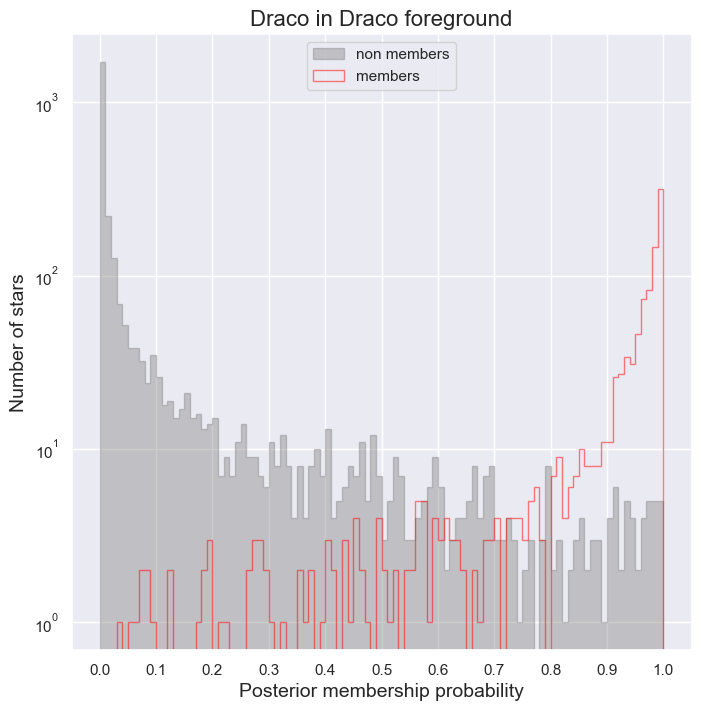

In [40]:
hist = histogram_prob(df, actual_members, nonmembers)

hist.savefig(path+glxName+"In"+bgName+"_NormFlow_GMM_histogram_LastProb.png", dpi=300, bbox_inches='tight')

In [41]:
def confusion_plots(table, members_threshold, nonmembers_threshold, members_indices):
    
    # Initialize sets for TP, FP, FN, TN
    Ndata = table.shape[0]

    P = "last_memb_posterior_prob"

    true_positive = np.where((table['source_id'].values == 42.0) & (table[P].values > members_threshold))[0]
    false_negative = np.where((table['source_id'].values == 42.0) & (table[P].values < nonmembers_threshold))[0]
    false_positive = np.where((table['source_id'].values != 42.0) & (table[P].values > members_threshold))[0]
    true_negative = np.where((table['source_id'].values != 42.0) & (table[P].values < nonmembers_threshold))[0]


    print('actual members: ',len(members_indices))
    print('true positive: ',len(true_positive))
    print('false positive: ',len(false_positive))
    print('')
    print('actual non members: ',Ndata-len(members_indices))
    print('true negative: ',len(true_negative))
    print('false negative: ',len(false_negative))


    # MAKING THE PLOT
    confusion_type = ['TP', 'FP', 'FN', 'TN']

    confusion_dict = {
        'TP': true_positive,
        'FP': false_positive,
        'FN': false_negative,
        'TN': true_negative
    }

    print(len(confusion_dict[confusion_type[0]]))

    fig, ax = plt.subplots(4, 3, figsize=(15, 20))
    fig.suptitle(f'Confusion plots {glxName} in {bgName}: thresholds {nonmembers_threshold} - {members_threshold}; members={len(members_indices)} non members={Ndata-len(members_indices)}', fontsize=18)
    for i in range(4):
        if confusion_type[i] == 'TP' or confusion_type[i] == 'FN':

            ax[i, 0].scatter(table['Xi'], table['Xn'], s=5, alpha=0.2, c='grey')
            ax[i, 0].scatter(table.loc[confusion_dict[confusion_type[i]], ['Xi']], table.loc[confusion_dict[confusion_type[i]], ['Xn']], s=10, c='red',
                             label=f'{confusion_type[i]}: {len(confusion_dict[confusion_type[i]])} - {len(confusion_dict[confusion_type[i]])/len(members_indices)*100:.2f}%')
            ax[i, 0].set_xlabel('Xi [deg]')
            ax[i, 0].set_ylabel('Xn [deg]')
            ax[i, 0].legend(loc='upper left', fontsize=13)

            ax[i, 1].scatter(table['PMra'], table['PMdec'], s=5, alpha=0.2, c='grey')
            ax[i, 1].scatter(table.loc[confusion_dict[confusion_type[i]], ['PMra']], table.loc[confusion_dict[confusion_type[i]], ['PMdec']], s=10, c='red')
            ax[i, 1].set_xlabel('PMra [mas/yr]')
            ax[i, 1].set_ylabel('PMdec [mas/yr]')

            ax[i, 2].scatter(table['BP0-RP0'], table['G0_c'], s=5, alpha=0.2, c='grey')
            ax[i, 2].scatter(table.loc[confusion_dict[confusion_type[i]], ['BP0-RP0']], table.loc[confusion_dict[confusion_type[i]], ['G0_c']], s=10, c='red')
            ax[i, 2].invert_yaxis()
            ax[i, 2].set_xlabel('BP0-RP0')
            ax[i, 2].set_ylabel('G0_c')

        else:

            ax[i, 0].scatter(table['Xi'], table['Xn'], s=5, alpha=0.2, c='grey')
            ax[i, 0].scatter(table.loc[confusion_dict[confusion_type[i]], ['Xi']], table.loc[confusion_dict[confusion_type[i]], ['Xn']], s=10, c='red',
                             label=f'{confusion_type[i]}: {len(confusion_dict[confusion_type[i]])} - {len(confusion_dict[confusion_type[i]])/(Ndata-len(members_indices))*100:.2f}%')
            ax[i, 0].set_xlabel('Xi [deg]')
            ax[i, 0].set_ylabel('Xn [deg]')
            ax[i, 0].legend(loc='upper left', fontsize=13)

            ax[i, 1].scatter(table['PMra'], table['PMdec'], s=5, alpha=0.2, c='grey')
            ax[i, 1].scatter(table.loc[confusion_dict[confusion_type[i]], ['PMra']], table.loc[confusion_dict[confusion_type[i]], ['PMdec']], s=10, c='red')
            ax[i, 1].set_xlabel('PMra [mas/yr]')
            ax[i, 1].set_ylabel('PMdec [mas/yr]')

            ax[i, 2].scatter(table['BP0-RP0'], table['G0_c'], s=5, alpha=0.2, c='grey')
            ax[i, 2].scatter(table.loc[confusion_dict[confusion_type[i]], ['BP0-RP0']], table.loc[confusion_dict[confusion_type[i]], ['G0_c']], s=10, c='red')
            ax[i, 2].invert_yaxis()
            ax[i, 2].set_xlabel('BP0-RP0')
            ax[i, 2].set_ylabel('G0_c')
    
    plt.tight_layout()
    plt.show()        
    
    return fig, true_positive, false_positive, false_negative, true_negative, len(members_indices), Ndata-len(members_indices)

In [42]:
# find the source_id of the contaminants in the real data
nonmembers_id_real = df_real[df_real['source_id'].isin(df['source_id'].loc[nonmembers])]
print(nonmembers.shape, nonmembers_id_real.shape)

actual_members_real = df_real[df_real['source_id'] == 42].copy()

# combine the two dataframes
df_combined = pd.concat([actual_members_real, nonmembers_id_real], ignore_index=True)
df_combined.reset_index(drop=True, inplace=True)

# Add the 'last_memb_posterior_prob' column from df to df_combined
df_combined['last_memb_posterior_prob'] = df['last_memb_posterior_prob'].values

df_combined.head()


(2965,) (2965, 15)


,Unnamed: 0,source_id,Xi,Xn,PMra,PMdec,BP0-RP0,G0_c,pmra_error,pmdec_error,bp_rp_error,pmra_pmdec_corr,phot_g_mean_mag_err,phot_bp_mean_mag_err,phot_rp_mean_mag_err,last_memb_posterior_prob
0,0,42,-0.104545,-0.037411,-0.320926,0.163968,1.113311,18.482388,0.147118,0.164161,0.002031,0.23,0.003257,0.028618,0.018263,0.683185
1,1,42,0.081207,0.094799,0.100331,-0.073985,1.135616,17.604562,0.092974,0.103509,0.001077,0.23,0.002954,0.014320,0.008869,0.998413
2,2,42,-0.045342,-0.057696,-0.174007,0.286449,0.983006,19.093861,0.214834,0.245956,0.002862,0.23,0.003763,0.046495,0.030768,0.970023
3,3,42,-0.102395,0.017652,0.329491,0.275948,0.135008,20.058642,0.424169,0.467016,0.000725,0.23,0.005901,0.065781,0.085121,0.998584
4,4,42,0.015912,-0.053953,-0.032379,-0.399486,0.982044,18.998001,0.203597,0.230907,0.002478,0.23,0.003648,0.039725,0.027152,0.987564


actual members:  1010
true positive:  666
false positive:  21

actual non members:  2965
true negative:  1923
false negative:  0
666


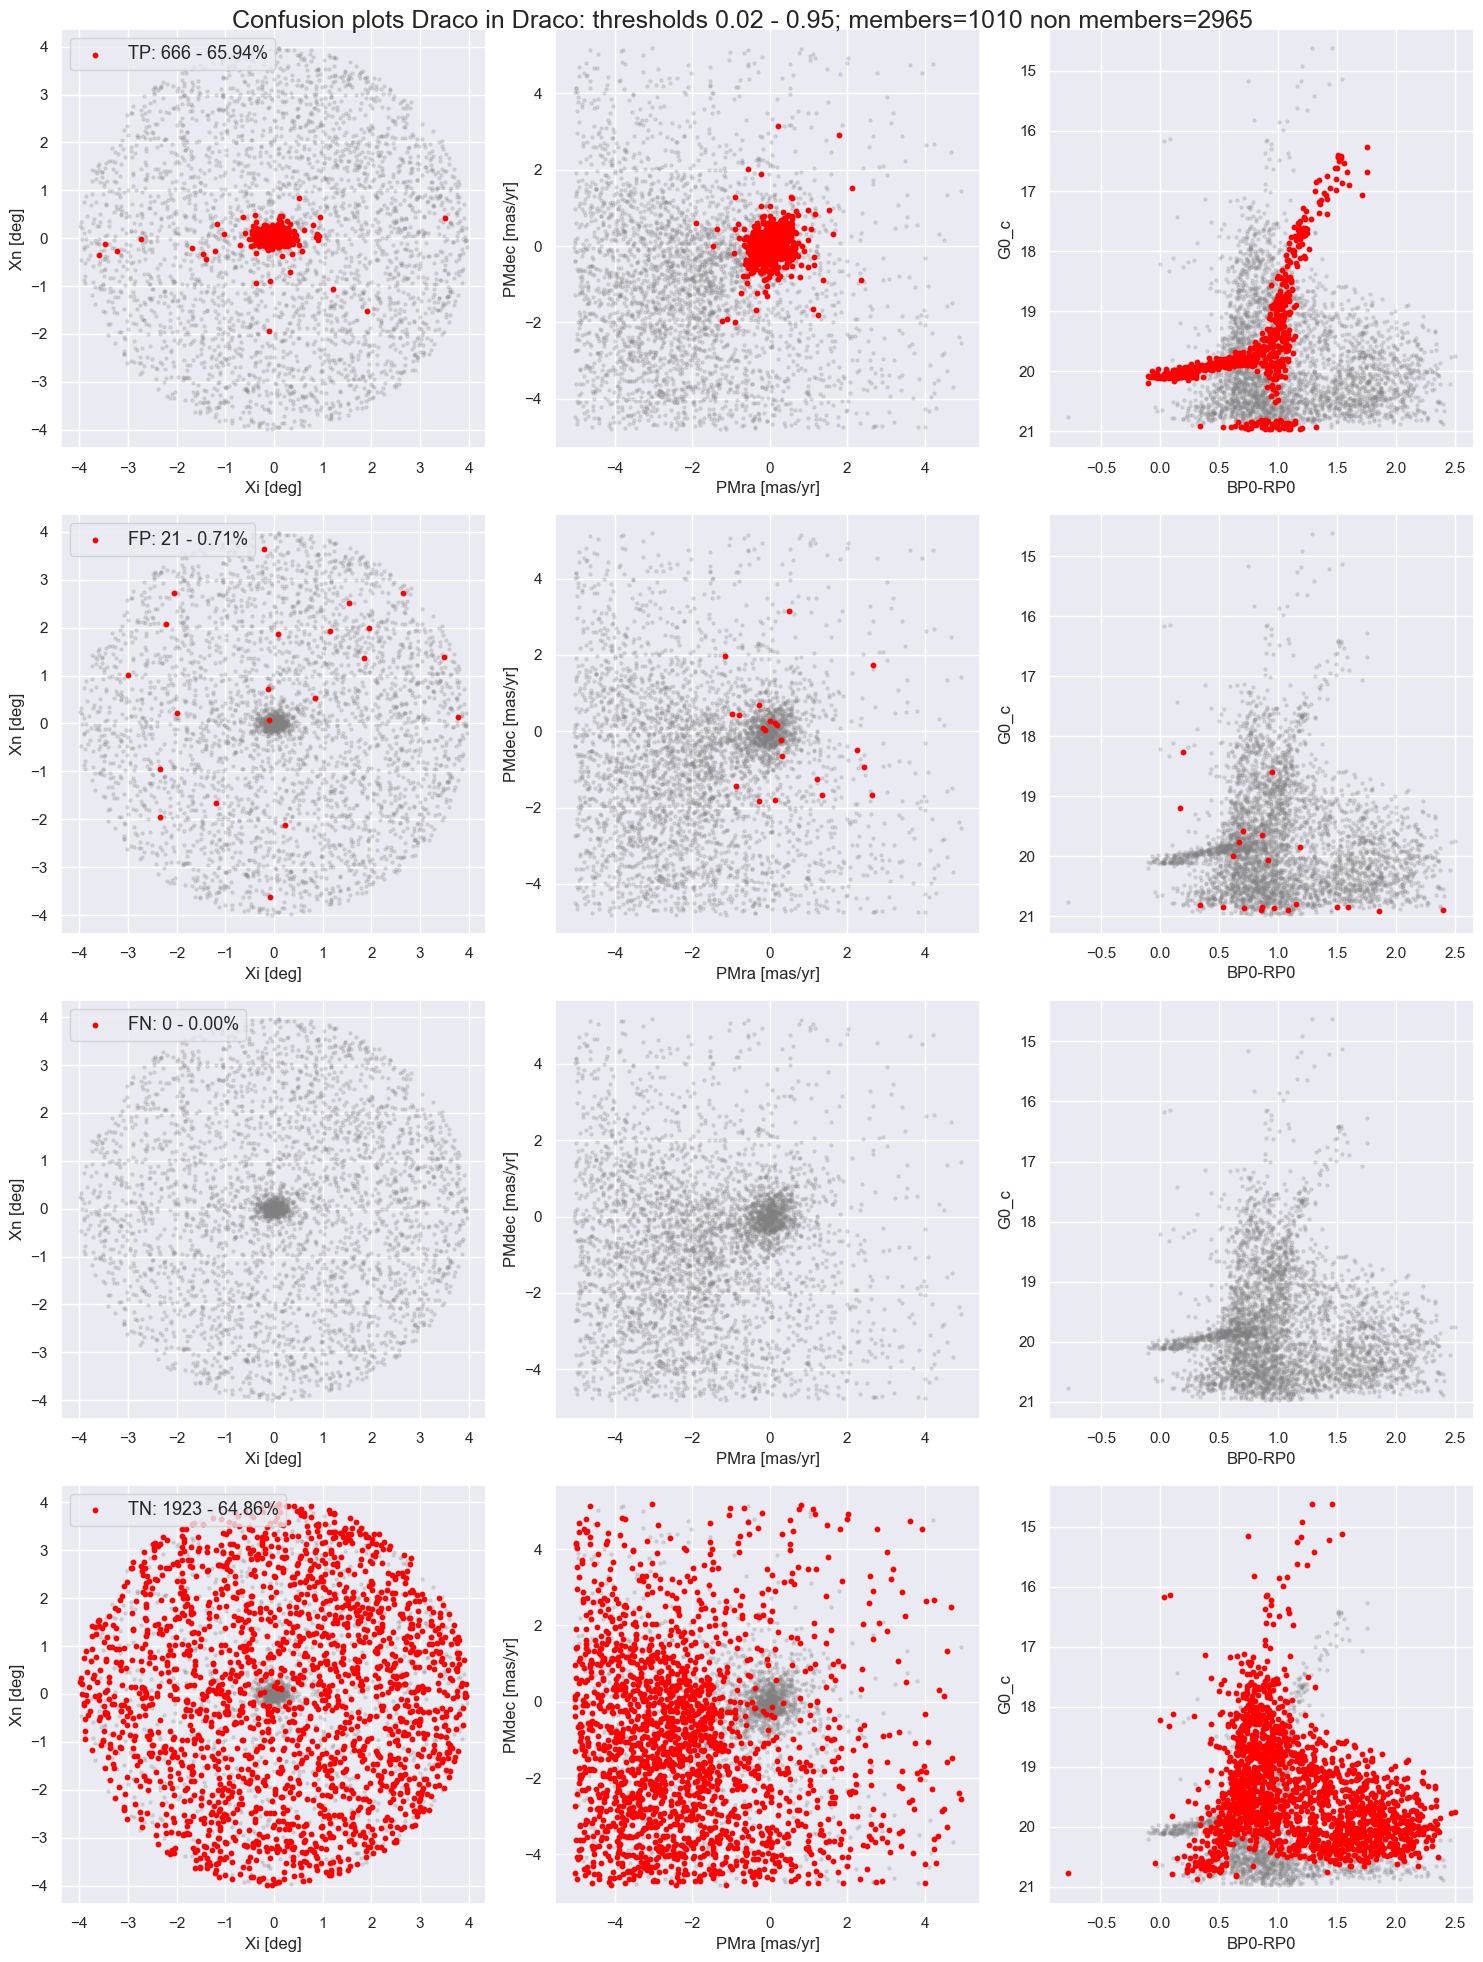

In [43]:
members_hreshold = 0.95
nonmembers_threshold = 0.02

df_confusion, TP, FP, FN, TN, members_count, nonmembers_count = confusion_plots(df_combined, members_hreshold, nonmembers_threshold, actual_members)

df_confusion.savefig(path+glxName+"In"+bgName+"_NormFlow_GMM_confusion_plots_002_095.png", dpi=300, bbox_inches='tight')

actual members:  1010
true positive:  795
false positive:  42

actual non members:  2965
true negative:  2338
false negative:  8
795


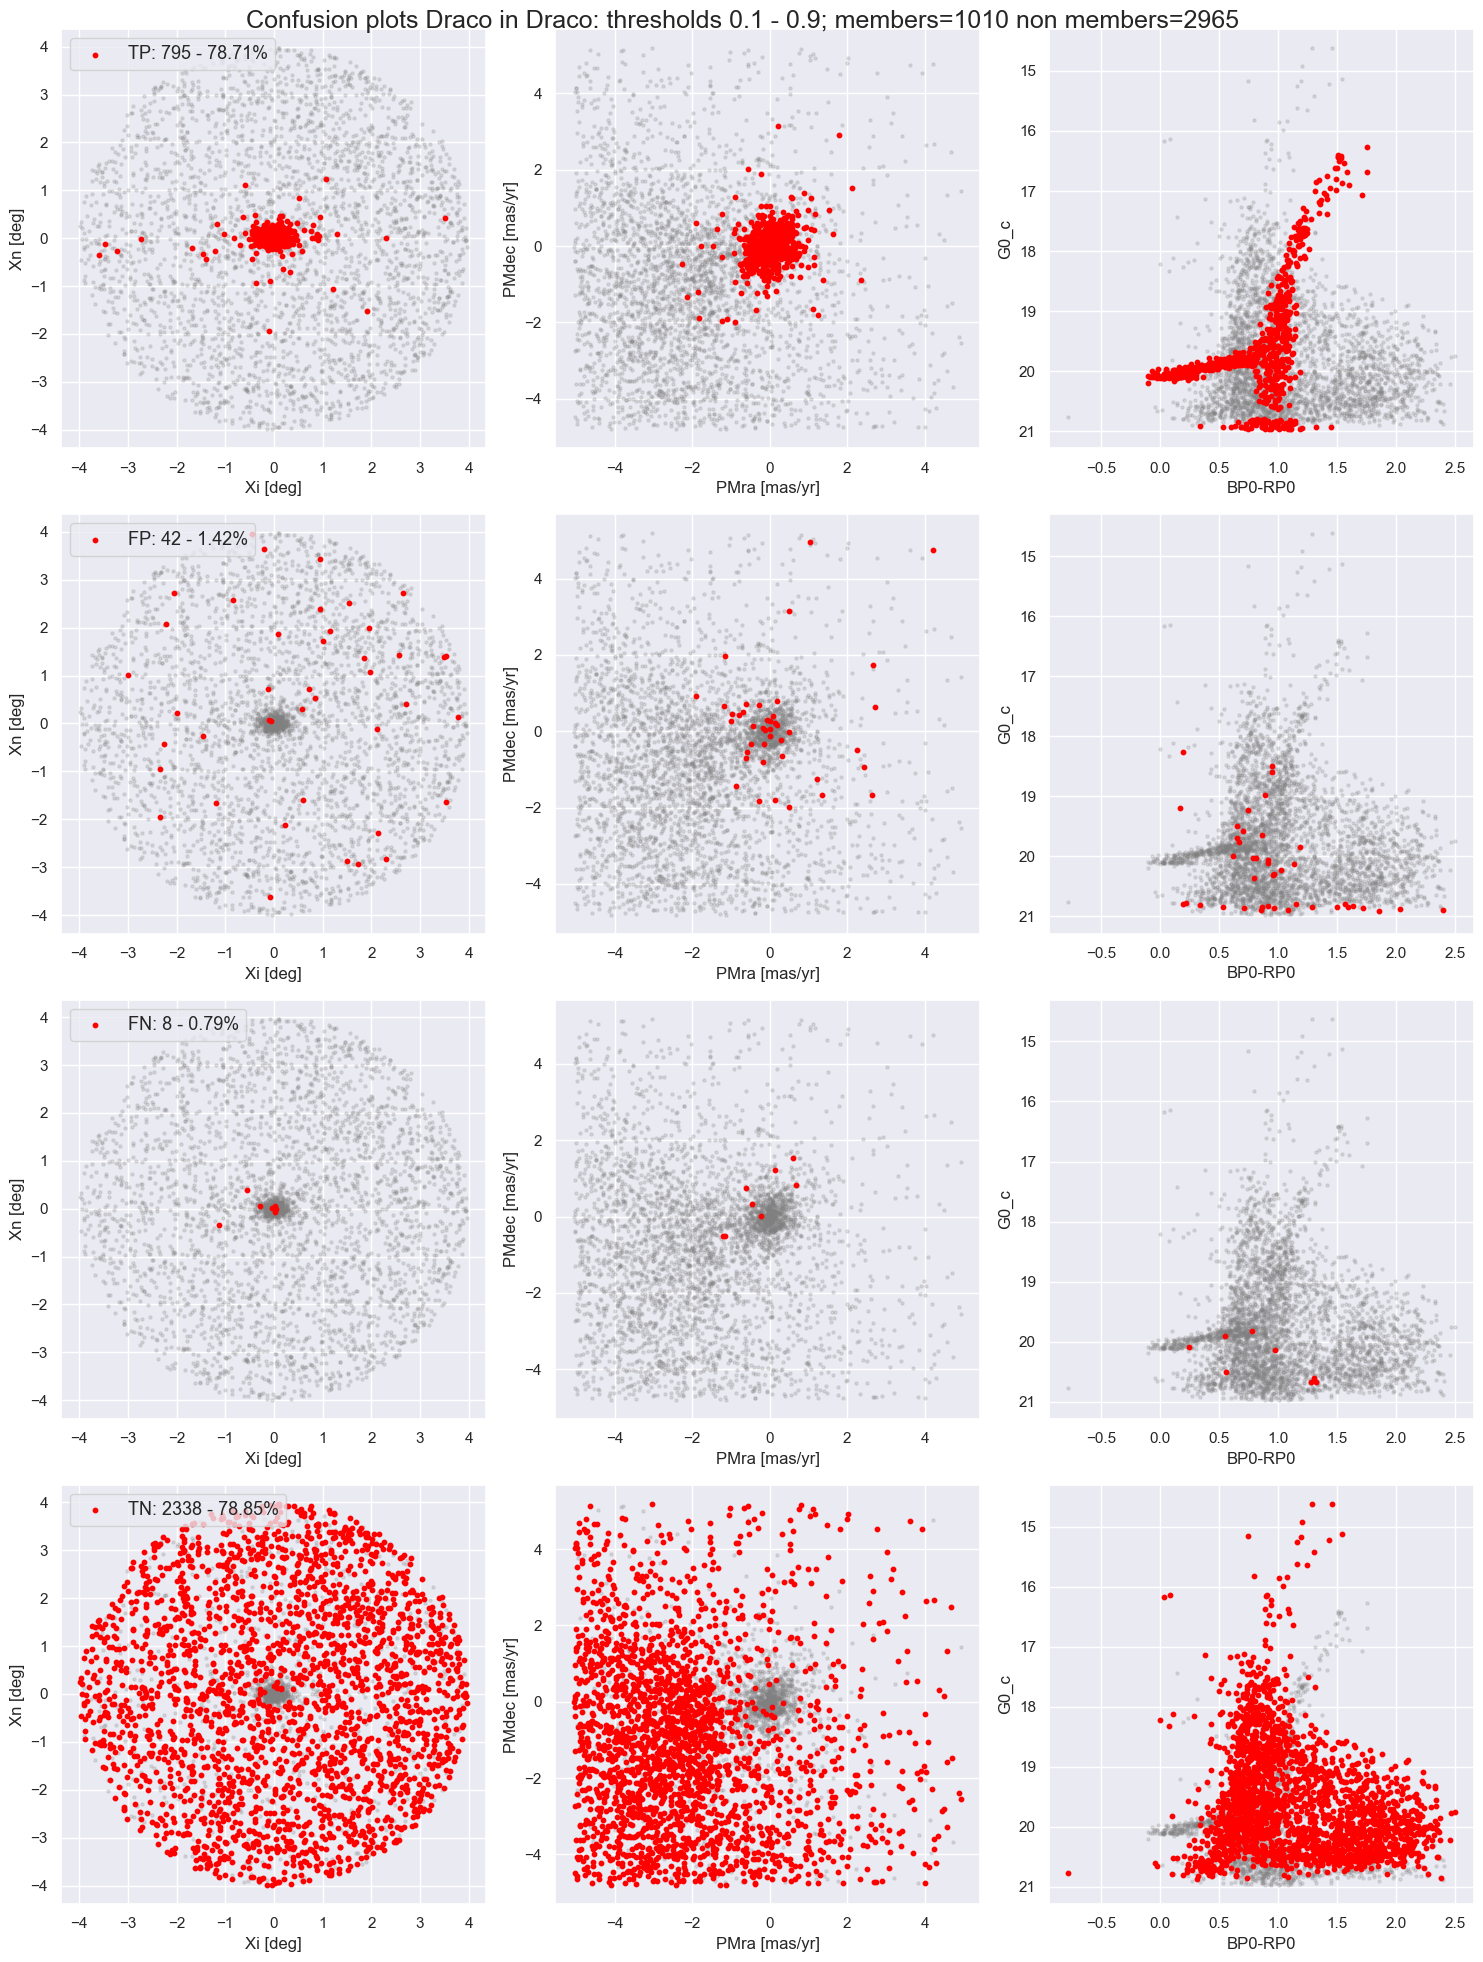

In [44]:
members_hreshold = 0.90
nonmembers_threshold = 0.1

df_confusion2, TP2, FP2, FN2, TN2, members_count2, nonmembers_count2 = confusion_plots(df_combined, members_hreshold, nonmembers_threshold, actual_members)

df_confusion2.savefig(path+glxName+"In"+bgName+"_NormFlow_GMM_confusion_plots_01_09.png", dpi=300, bbox_inches='tight')

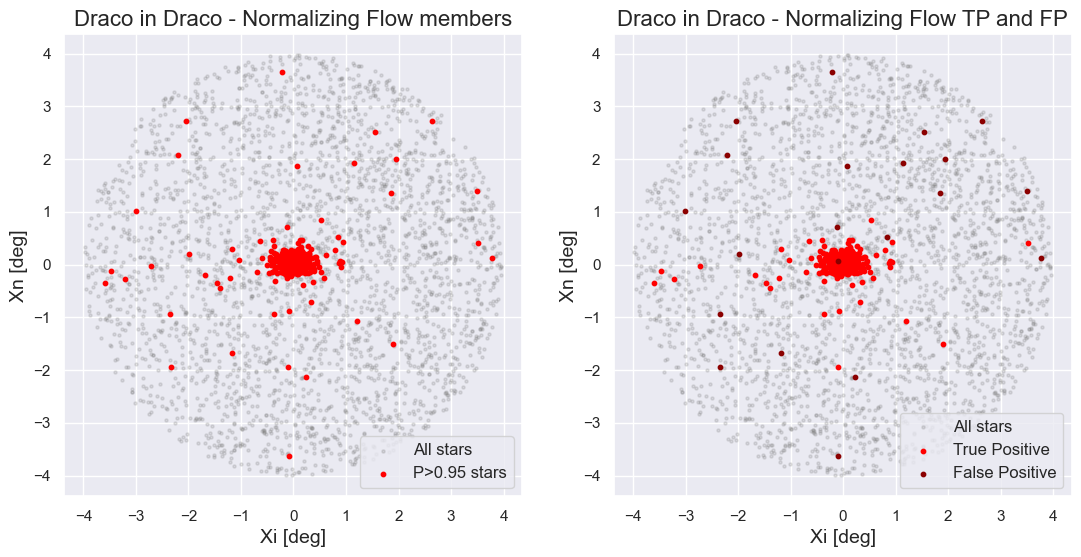

In [45]:
# PLOTTING ONLY THE MEMBERS OBTAINED FROM THE CONFUSION MATRIX

fig, ax = plt.subplots(1,2, figsize=(13, 6))

ax[0].scatter(df_combined['Xi'], df_combined['Xn'], s=5, alpha=0.2, c='grey', label='All stars')
ax[0].scatter(df_combined.loc[TP, ['Xi']], df_combined.loc[TP, ['Xn']], s=10, c='red', label='P>0.95 stars')
ax[0].scatter(df_combined.loc[FP, ['Xi']], df_combined.loc[FP, ['Xn']], s=10, c='red')
ax[0].set_xlabel('Xi [deg]', fontsize=14)
ax[0].set_ylabel('Xn [deg]', fontsize=14)
ax[0].legend(loc='lower right', fontsize=12)
ax[0].set_title(f'{glxName} in {bgName} - Normalizing Flow members', fontsize=16)

ax[1].scatter(df_combined['Xi'], df_combined['Xn'], s=5, alpha=0.2, c='grey', label='All stars')
ax[1].scatter(df_combined.loc[TP, ['Xi']], df_combined.loc[TP, ['Xn']], s=10, c='red', label='True Positive')
ax[1].scatter(df_combined.loc[FP, ['Xi']], df_combined.loc[FP, ['Xn']], s=10, c='darkred', label='False Positive')
ax[1].set_xlabel('Xi [deg]', fontsize=14)
ax[1].set_ylabel('Xn [deg]', fontsize=14)
ax[1].legend(loc='lower right', fontsize=12)
ax[1].set_title(f'{glxName} in {bgName} - Normalizing Flow TP and FP', fontsize=16)

fig.savefig(path+glxName+"In"+bgName+"_NormFlow_GMM_outputs_members.png", dpi=300, bbox_inches='tight')